In [1]:
import os
import sys
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
sys.path.append(os.path.join(PROJ_ROOT, 'src'))

%matplotlib inline
%config InlineBackend.figure_format ='retina'

%load_ext autoreload
%autoreload 2

%aimport data, model, features, plot

import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from model.baselineestimator import estimate
from model.evaluation import score_rmse
from model.training import train
import features.selection as feature_selection
import features.extraction as feature_extraction
from sklearn.feature_selection import VarianceThreshold

In [2]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

In [3]:
from data.dataset import DataSet

traindf = DataSet.traindf[np.unique(DataSet.traindf.columns)]
testdf = DataSet.testdf[np.unique(DataSet.testdf.columns)]

traindf.shape

(249876, 915)

### Exclude features by variance & NaNs percent

In [4]:
feature_variance_selector = VarianceThreshold(threshold=(.80 * (1 - .80))).fit(traindf)
high_variance_features = traindf.columns[feature_variance_selector.get_support(indices=True)]
informative_features = feature_selection.non_empty_columns(traindf[high_variance_features], nans_threshold=60)

In [5]:
traindf[informative_features].shape

(249876, 441)

In [6]:
regressor = LGBMRegressor(random_state=0)
# feat = ['pay_sum_min_mnt1', 'pay_sum_max_mnt1','target']
regressor.fit(traindf[informative_features].drop(columns='target'), traindf.target)
regressor.score(testdf[informative_features].drop(columns='target'),testdf.target)

0.44705706137986667

In [7]:
f"RMSE: {score_rmse(testdf.target, regressor.predict(testdf[informative_features].drop(columns='target'))):.3f}"

'RMSE: 8.653'

In [137]:
df = testdf[informative_features].sample(50000)
permutation_importance_result = permutation_importance(regressor, df.drop(columns='target'), df.target, n_repeats=10, random_state=0)

In [11]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(traindf.columns, regressor.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
sdf = importances.sort_values(by='importance')

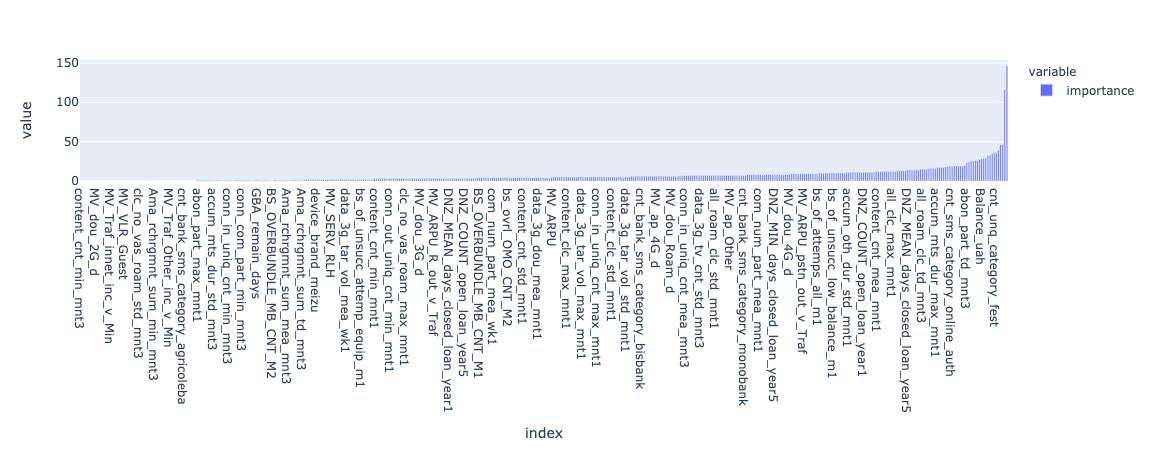

In [12]:
tree_importance_sorted_idx = np.argsort(regressor.feature_importances_)
tree_indices = np.arange(0, len(tree_importance_sorted_idx))
fig = px.bar(sdf)
fig.show()

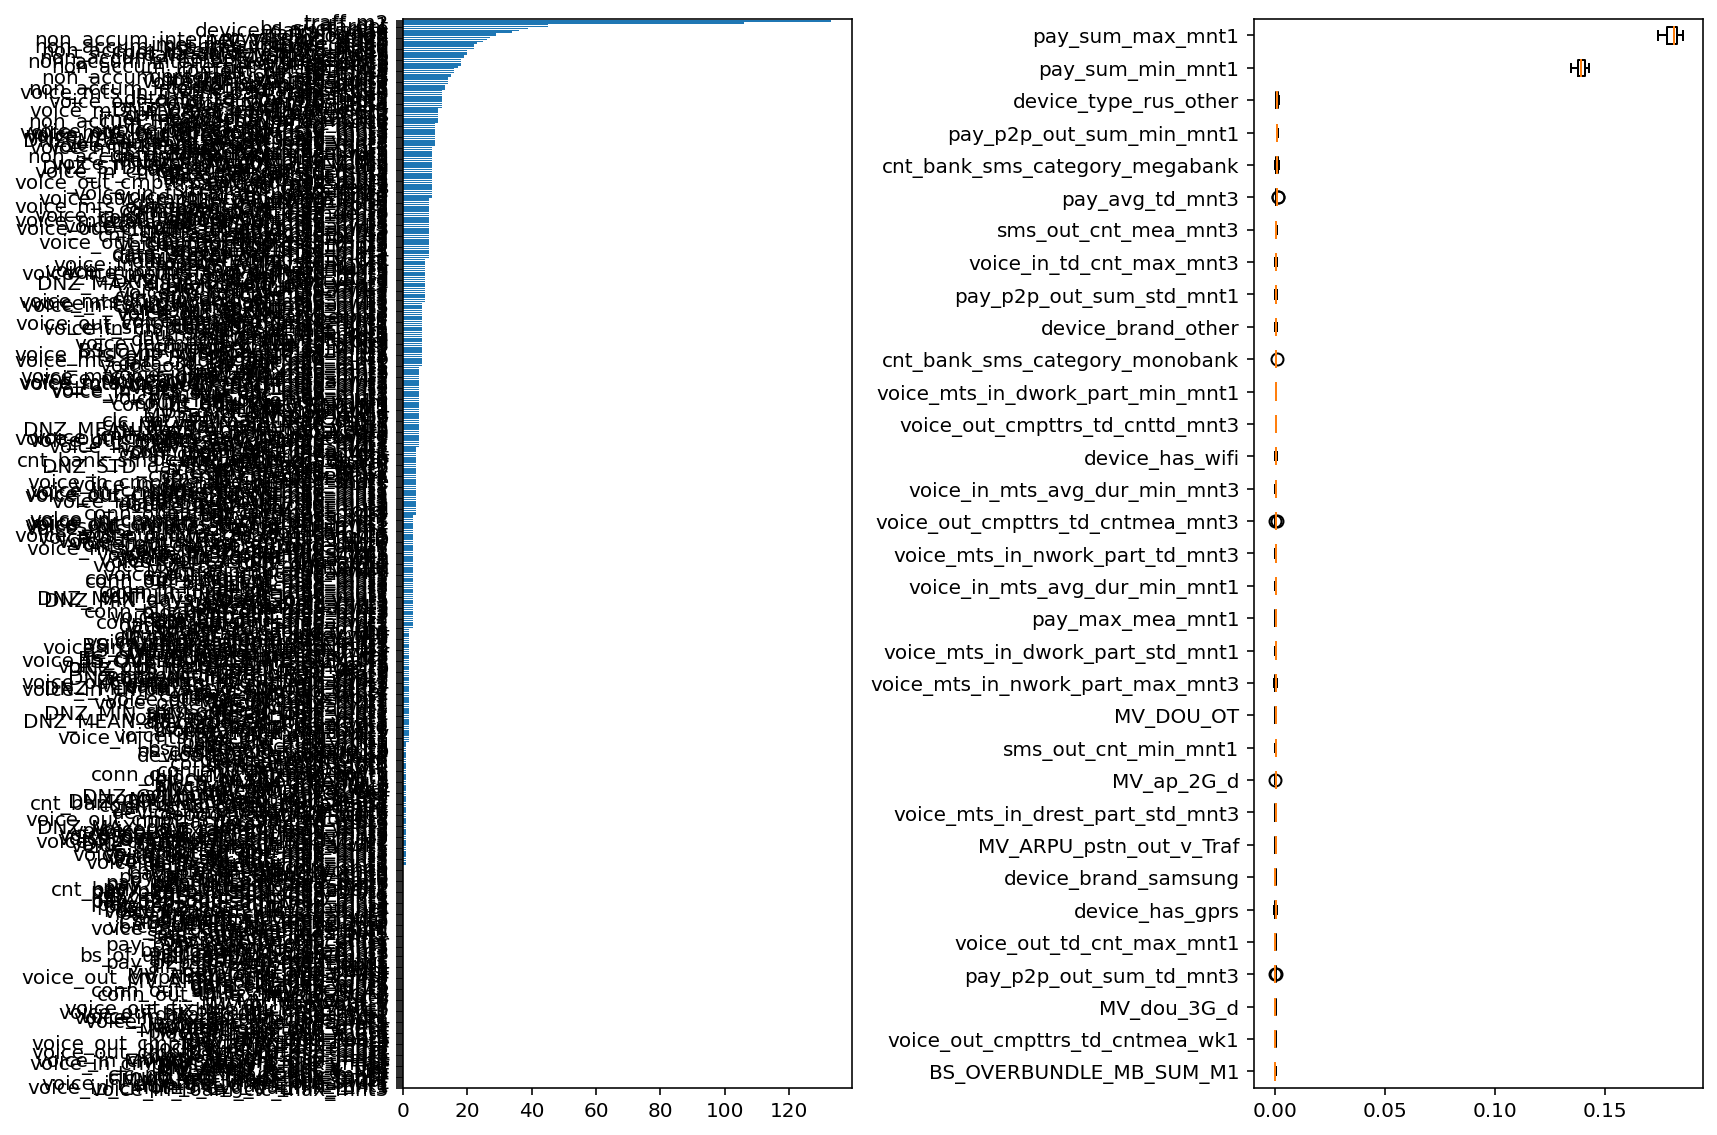

In [148]:
perm_sorted_idx = permutation_importance_result.importances_mean.argsort()[550:]

tree_importance_sorted_idx = np.argsort(regressor.feature_importances_)
tree_indices = np.arange(0, len(tree_importance_sorted_idx))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, regressor.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(df.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(regressor.feature_importances_)))
ax2.boxplot(permutation_importance_result.importances[perm_sorted_idx].T, vert=False,labels=testdf.columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

In [6]:
ddf = traindf[informative_features].fillna(traindf[informative_features].median())

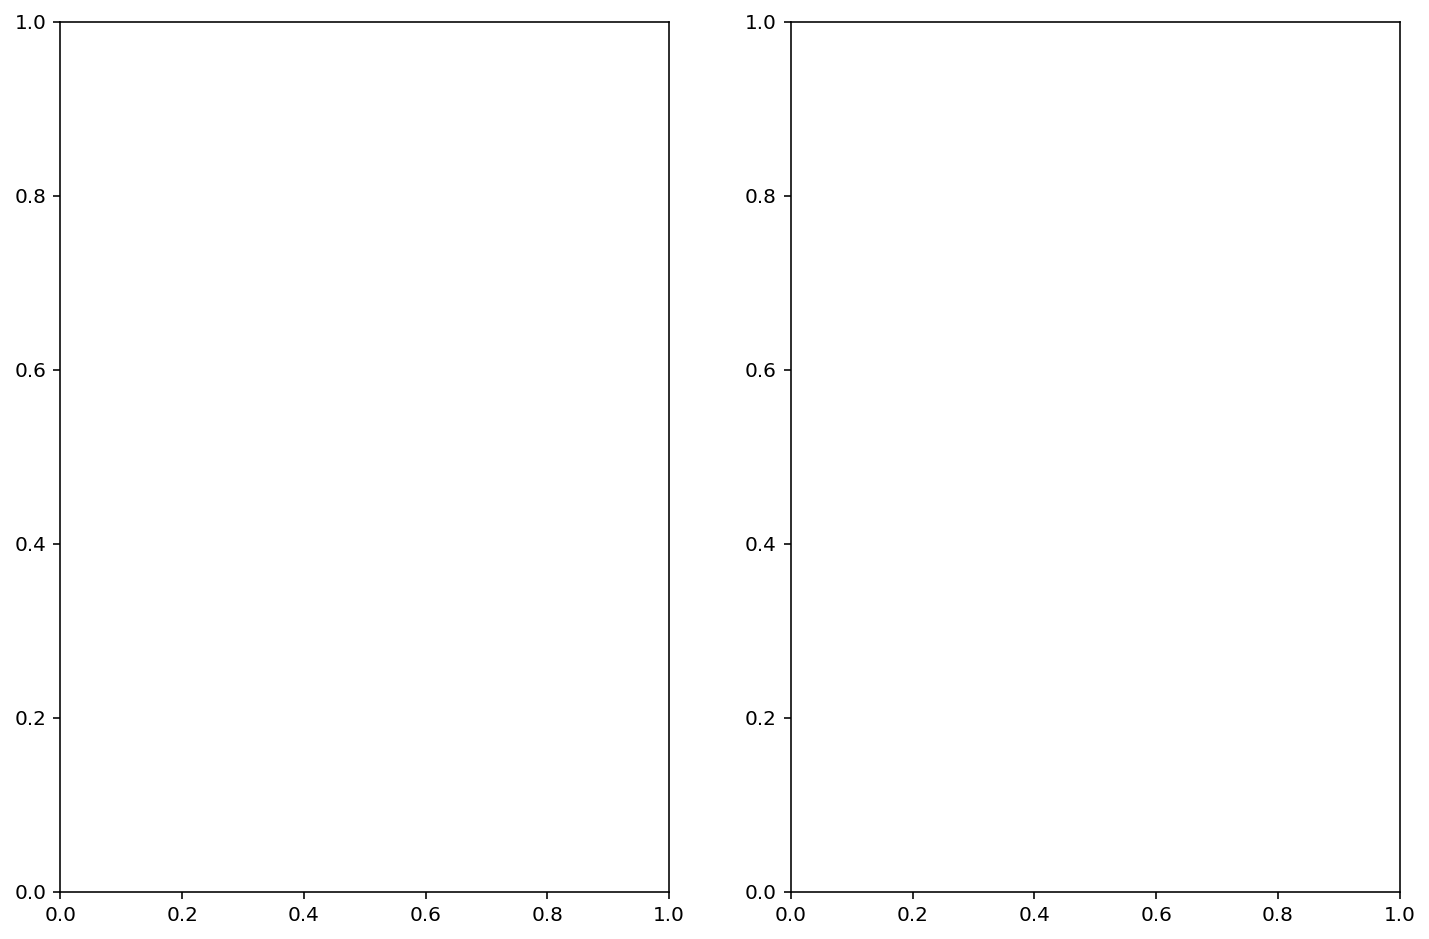

In [14]:
corr = traindf[informative_features].corr().fillna(0)
corr_linkage = hierarchy.ward(corr)

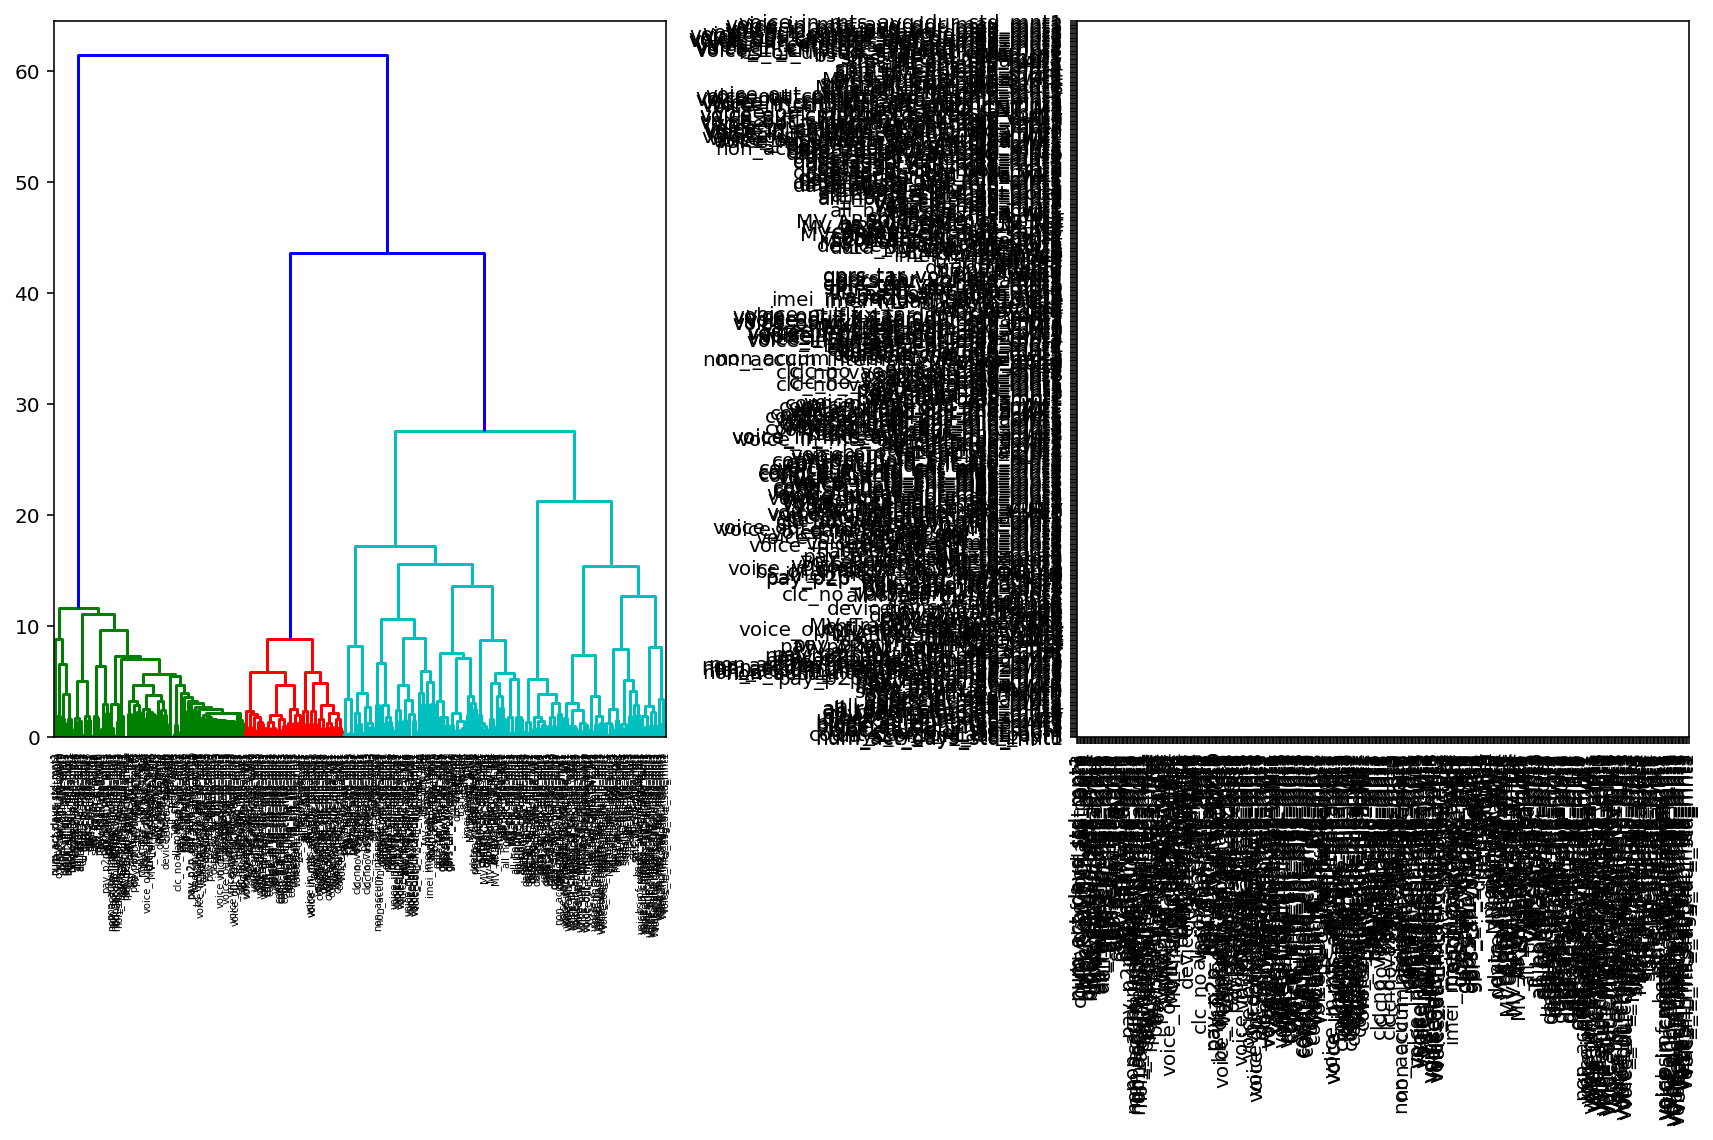

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
dendro = hierarchy.dendrogram(
    corr_linkage, labels=traindf[informative_features].columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

# ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [9]:
df = traindf
target = df.target
df = df.drop(columns={'target'})
# df = df.fillna(df.median())
greenf , bluef = feature_selection.boruta(df, target)

In [10]:
greenf

['device_days_usage',
 'bs_succ_rate',
 'non_accum_internet_vol_min_mnt3',
 'traff_m5',
 'traff_m1',
 'traff_mean']

In [11]:
bluef

['device_price',
 'loc_lon',
 'MV_Traf_4G_d_Mb',
 'non_accum_internet_vol_mea_mnt1',
 'non_accum_internet_vol_max_mnt1',
 'non_accum_internet_vol_min_mnt1',
 'non_accum_internet_vol_std_mnt1',
 'non_accum_internet_vol_td_mnt3',
 'content_cnt_std_mnt3',
 'dpi_upload',
 'myvf_day_usage',
 'traff_min',
 'traff_max',
 'traff_std']

In [13]:
corrf = feature_selection.correlation(traindf, 'target')

In [28]:
choosed_features = list(set(corrf.index).union(greenf).union(bluef).union(['traff_m4', 'loc_lat']))

In [31]:
df = traindf.sample(100)
X = df[choosed_features]
y = df.target

In [57]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(traindf, traindf.target)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=traindf.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [63]:
mi_scores[:50].index

Index(['target', 'traff_median', 'traff_m1', 'traff_mean', 'traff_max',
       'traff_min', 'traff_m2', 'dpi_download', 'traff_m3',
       'non_accum_internet_vol_max_mnt3', 'traff_m4', 'traff_m5',
       'non_accum_internet_vol_std_mnt3', 'dpi_upload', 'traff_std',
       'non_accum_internet_vol_std_mnt1', 'TM_ID', 'MV_ap_4G_d',
       'MV_ap_innet_out_v', 'clc_no_vas_roam_std_mnt3',
       'clc_no_vas_roam_max_mnt3', 'all_clc_std_mnt3', 'dpi_events',
       'MV_AP_total', 'MV_ap_omo_out_v', 'MV_ap_pstn_out_v', 'dpi_duration',
       'data_3g_tar_vol_max_mnt3', 'clc_no_vas_roam_max_mnt1',
       'clc_no_vas_roam_std_mnt1', 'data_3g_tar_vol_std_mnt3',
       'data_3g_tar_vol_mea_mnt3', 'all_clc_max_mnt3', 'all_clc_max_mnt1',
       'data_3g_tar_vol_max_mnt1', 'all_clc_std_mnt1',
       'data_3g_tar_vol_mea_mnt1', 'MV_Traf_4G_d_Mb',
       'data_3g_tar_vol_std_mnt1', 'all_clc_mea_mnt1',
       'clc_no_vas_roam_mea_mnt3', 'all_clc_mea_mnt3', 'MV_ARPU',
       'pay_max_std_mnt3', 'pay_sum

In [48]:
from sklearn.feature_selection import SequentialFeatureSelector
from lightgbm import LGBMRegressor

sfs_forward = SequentialFeatureSelector(LGBMRegressor(), n_features_to_select=15).fit(X, y)

In [49]:
print("Features selected by forward sequential selection: "
    f"{X.columns[sfs_forward.get_support()].tolist()}")

Features selected by forward sequential selection: ['traff_median', 'device_days_usage', 'traff_m1', 'non_accum_internet_vol_std_mnt3', 'traff_std', 'non_accum_internet_vol_td_mnt3', 'loc_lon', 'gprs_tar_vol_std_mnt3', 'non_accum_internet_vol_mea_mnt1', 'traff_min', 'non_accum_internet_vol_std_mnt1', 'traff_mean', 'device_price', 'non_accum_internet_vol_max_mnt1', 'myvf_day_usage']


In [13]:
nonemptycolset = set(feature_selection.non_empty_columns(traindf, nans_threshold=30))

In [10]:
statscolsset = set(feature_extraction.statistic_columns(traindf.columns))
colsset = set(traindf.columns)

In [11]:
nonstatcolset = colsset.difference(statscolsset)

In [19]:
nonemptyandnonstatscols = list(nonstatcolset.intersection(nonemptycolset))

In [20]:
traindf[nonemptyandnonstatscols] = traindf[nonemptyandnonstatscols].fillna(traindf[nonemptyandnonstatscols].median())